# Archive

In [ ]:
!cp /content/drive/MyDrive/captcha_solver.zip .
!unzip captcha_solver.zip

Archive:  captcha_solver.zip
   creating: captcha_solver/
  inflating: captcha_solver/captcha.jpg  
  inflating: captcha_solver/captcha2.jpg  
  inflating: captcha_solver/captcha_cutted.jpg  
  inflating: captcha_solver/captcha_cutted_total.jpg  
  inflating: captcha_solver/Center_cropped.jpg  
  inflating: captcha_solver/Center_cropped_1.jpg  
  inflating: captcha_solver/img_masked.jpg  
  inflating: captcha_solver/img_masked2.jpg  
  inflating: captcha_solver/img_masked_smooth.jpg  
  inflating: captcha_solver/img_masked_white.jpg  
  inflating: captcha_solver/mask.jpg  
  inflating: captcha_solver/Mask_gimp.jpg  
  inflating: captcha_solver/Mask_gimp_post.jpg  
  inflating: captcha_solver/mask_smooth.jpg  
  inflating: captcha_solver/rotated.jpg  
  inflating: captcha_solver/RotGenerator.py  
  inflating: captcha_solver/RotGenerator_v2.py  
  inflating: captcha_solver/rotnet.jpg  
 extracting: captcha_solver/Wymiary.txt  


In [ ]:
%cd captcha_solver/

/content/captcha_solver


IMAGE 1


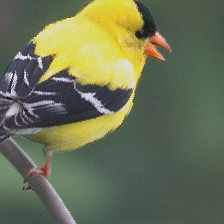

SHAPE SZUKANY
(130, 130, 3)
ANGLE 248
MASK CENTER


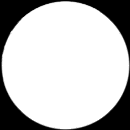

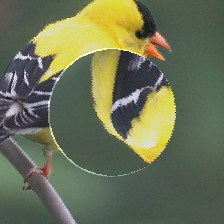

DODAJ BIALE 1


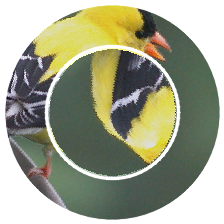

In [ ]:
import cv2 as cv
import random
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow


'''
Dodac wariancje w generowanych dancyh jesli chodzi o grubosc pierscieni
zeby nie mialo to znaczenia czy jest piksel grubszy czy o 5 inny itd !
'''



def rotate_pil(img_pth="rotnet.jpg", save=False, show=False):
    '''
    Function which load image and rotate it by random angle and cut
    then converts to cv2 format (np.array)

    --------------------------
    RETURNS:
        open_cv_image :  numpy array - preprocessed image
    '''
    img = Image.open(img_pth).convert('RGB')
    angle = random.randint(1, 359)
    rotate_img= img.rotate(angle)

    width, height = rotate_img.size   # Get dimensions
    new_width = 224
    new_height = 224

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    cropped_img = rotate_img.crop((left, top, right, bottom))

    if show is True:
        cropped_img.show()
    if save is True:
        cropped_img.save("rotated.jpg")


    open_cv_image = np.array(cropped_img)
    # Convert RGB to BGR
    open_cv_image = open_cv_image[:, :, ::-1].copy()

    return open_cv_image

def generate_smooth_mask(x_size=224, y_size=224, save=False):
    '''
    Function Generate mask and smooth the edges
    --------------------------------------
    Parameters
        x_size, y_size: int - height and width of image

    --------------------------------------
    Attributes
        thickness if -1 mean fill all inside
        r - radius
    '''
    # define attributes
    black = (0, 0, 0)
    white = (255, 255, 255)
    thickness = -1
    r1 = 107
    r2 = 67
    r3 = 64
    center_coordinates = (int(x_size/2), int(y_size/2))

    # generate mask
    mask = np.zeros((x_size, y_size), dtype="uint8")
    mask = mask + 255 # to make white
    # draw mask
    mask = cv.circle(mask, center_coordinates, r1, black, thickness, lineType=cv.LINE_AA)
    mask = cv.circle(mask, center_coordinates, r3, black, thickness, lineType=cv.LINE_AA)
    mask = cv.circle(mask, center_coordinates, 66, white, 1, lineType=cv.LINE_AA)

    if save is True:
        cv.imwrite("mask_smooth.jpg", mask)

    return mask

def mask_image(img, mask, save=False):
    '''
    Concat mask with image
    '''

    # more smooth
    #kernel2 = np.ones((5, 5), np.float32)/25
    #mask = cv.filter2D(src=mask, ddepth=-1, kernel=kernel2)
    #blur = cv.GaussianBlur(mask, (0,0), sigmaX=3, sigmaY=3, borderType = cv.BORDER_DEFAULT)
    #result = skimage.exposure.rescale_intensity(blur, in_range=(127.5,255), out_range=(0,255))
    #result = result.astype(np.uint8)
    #print(result.shape)
    #print(result.dtype)
    #cv.imwrite("mask_smooth.jpg", result)
    masked = cv.bitwise_not(img, img, mask=mask)
    if save is True:
        cv.imwrite("img_masked_smooth.jpg", masked)
    return masked

def dodaj_biale(image, save=False):
    '''
    Dodaje biale tlo poniewaz bitwise daje negatyw zamiast tla XD
    '''
    white = (255, 255, 255)
    image = cv.circle(image, (112,112), 66, white, 2, lineType=cv.LINE_AA)
    image = cv.circle(image, (112,112), 160, white, 103, lineType=cv.LINE_AA)
    if save is True:
        cv.imwrite("img_masked_white.jpg", image)
    return image

def rotuj_srodkiem(img, save=False):
    '''
    1. wytnij se srodek + 1 pixel zapasu bialego
    2. zamaluj czarnym na zew
    3. wklej maske i zapamietaj kat

    Da sie szybiecj funkcja na poczatku 2 razy obrocic i zapisac !

    '''

    new_img = img.copy()
    w=130
    h=130
    center = new_img.shape
    x = center[1]/2 - w/2
    y = center[0]/2 - h/2

    crop_img = new_img[int(y):int(y+h), int(x):int(x+w)]


    # maske zrobic
    crop_img = cv.circle(crop_img, (65,65), 80, (0,0,0), 29, lineType=cv.LINE_AA) # black

    # rotate and convert to PIL
    crop_img = cv.cvtColor(crop_img, cv.COLOR_BGR2RGB)
    im_pil = Image.fromarray(crop_img).convert('RGB')
    angle = random.randint(1, 359)
    rotate_img= im_pil.rotate(angle)

    # back to cv2
    rotated_circle = np.array(rotate_img)
    # Convert RGB to BGR
    rotated_circle = rotated_circle[:, :, ::-1].copy()

    # Make mask
    print("SHAPE SZUKANY")
    print(crop_img.shape)
    mask = cv.circle(crop_img, (65,65), 63, (255,255,255), -1, lineType=cv.LINE_AA)
    mask = mask [:,:,0]

    if save is True:
        cv.imwrite("Center_cropped.jpg", rotated_circle)
        cv.imwrite("Center_cropped_mask.jpg", mask)

    return rotated_circle, mask, angle

# 
# https://docs.opencv.org/4.x/d0/d86/tutorial_py_image_arithmetics.html
def wklej_zrotowane(base_image, rotated_circle, mask):
    # FIND ROI czyli od srodka po 65 w kazda strone
    #print("BASE IMG")
    #cv2_imshow(base_image)
    w=130
    h=130
    center = base_image.shape
    x = center[1]/2 - w/2
    y = center[0]/2 - h/2
    crop_img = base_image[int(y):int(y+h), int(x):int(x+w)]

    #print("CROP_IMG")
    #cv2_imshow(crop_img)
    mask_inv = cv.bitwise_not(mask) # MASKA DLA CROP_IMG
    #print("ROTATED CIRCLE")
    #cv2_imshow(rotated_circle)
    #print("MASK")
    #cv2_imshow(mask)

    # background
    img1_bg = cv.bitwise_and(crop_img,crop_img,mask = mask_inv)
    # foreground
    img2_fg = cv.bitwise_and(rotated_circle,rotated_circle,mask = mask)

    dst = cv.add(img1_bg,img2_fg)

    base_image[int(y):int(y+h), int(x):int(x+w)] = dst

    #cv2_imshow(base_image)


    ##print(base_image.shape)
    #print(crop_img.shape)
    #print(rotated_circle.shape)
    #print(mask.shape)
    return base_image

def main():
    image = rotate_pil(save=False, show=False) # rotated.jpg
    print("IMAGE 1")
    cv2_imshow(image)
    #mask = generate_smooth_mask(save=True) # mask_smooth.jpg
    #print("MASK 1")
    #cv2_imshow(mask)
    #image = mask_image(image, mask, save=True)
    #print("MASKED IMAGE 1")
    #cv2_imshow(image)
    #image = dodaj_biale(image, save=True)
    #print("DODAJ BIALE 1")
    #cv2_imshow(image)  
    rotated_circle, mask_center, angle = rotuj_srodkiem(image, save=True)
    print(f"ANGLE {angle}")
    print("MASK CENTER")
    cv2_imshow(mask_center)
    final_img = wklej_zrotowane(image, rotated_circle, mask_center)
    cv2_imshow(final_img)
    final_img = dodaj_biale(final_img, save=True)
    print("DODAJ BIALE 1")
    cv2_imshow(final_img)  
main()


# IMAGE GENERATOR

1. zrobic plik df ze scieszkami z imagenet z kaggle
2. preprocess wpisac w dataloader pytorchowy
3. polaczyc robienie mask wszystkich 3 w jedna funkcje
4. dwa razy zrotowac na poczatku w celu przyspieszenia

* napisac sobie klase do preprocessu
* a w pytorchowej uzyc juz tylko standardu




```
w przyszlosci dodac losowosc o iles pixeli oddal przybliz itd
```



In [ ]:
# ZMIENIC KOLEJNOSC Z KOPIOWANIEM ITD JESLI UZYWASZ DALEJ CAPTCHA_SOLVER DIR


!cp /content/drive/MyDrive/kaggle.json .
!cp /content/drive/MyDrive/rotnet.jpg .
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ifigotin/imagenetmini-1000
!unzip /content/imagenetmini-1000.zip

In [ ]:
import os
import pandas as pd
filenames = [] # 38668 plikow
for root, dirs, files in os.walk("/content/imagenet-mini"):
    for file in files:
        if file.endswith(".JPEG"):
            filenames.append(os.path.join(root, file))
            
df = pd.DataFrame(filenames, columns=['filename'])
print(len(filenames))


df

35257


,filename
0,/content/imagenet-mini/train/n02098286/n020982...
1,/content/imagenet-mini/train/n02098286/n020982...
2,/content/imagenet-mini/train/n02098286/n020982...
3,/content/imagenet-mini/train/n02098286/n020982...
4,/content/imagenet-mini/train/n02098286/n020982...
...,...
35252,/content/imagenet-mini/val/n04525305/ILSVRC201...
35253,/content/imagenet-mini/val/n04525305/ILSVRC201...
35254,/content/imagenet-mini/val/n03255030/ILSVRC201...
35255,/content/imagenet-mini/val/n03255030/ILSVRC201...


In [ ]:
import imagesize
from tqdm import tqdm

too_small_path = []
for idx, filepath in tqdm(enumerate(filenames)):
    w, h = imagesize.get(filepath)
    if h < 224 or w < 224:
        too_small_path.append(filepath)
print("\n")
print("za maly plik")
print(len(too_small_path))

38668it [00:00, 39658.88it/s]



za maly plik
3411


In [ ]:
import os
for file in too_small_path:
    if os.path.exists(file):
        os.remove(file)
    else:
        print("The file does not exist") 

#### EDA TZN SPRAWDZ WYMIARY 224 x 224

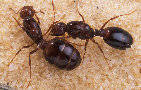

In [ ]:
#too_small_path
from google.colab.patches import cv2_imshow
import cv2 as cv
too_small = '/content/imagenet-mini/train/n02219486/n02219486_15826.JPEG'

img = cv.imread(too_small)
cv2_imshow(img)

In [ ]:
import imagesize
import time



start_time = time.time()
width, height = imagesize.get("/content/rotnet.jpg") # --- 0.00136566162109375 seconds ---
#h, w = cv.imread("/content/rotnet.jpg").shape[:2] # --- 0.008667230606079102 seconds ---
print("--- %s seconds ---" % (time.time() - start_time))
print(width, height)


--- 0.011051416397094727 seconds ---
500 318


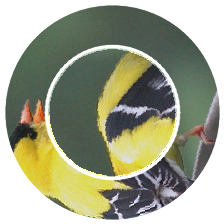

90


In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
import cv2 as cv
import random
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd


class Process_image():
    '''
    MODE 1
    klasyfikacja:
    50%
    50%
    Sprawdzic tez inne

    MODE 2
    Regresja
    '''
    def __init__(self):
        return

    def rotate_pil(self, label, img_pth="rotnet.jpg", save=False, show=False):
        '''
        Function which load image and rotate it by random angle and cut
        then converts to cv2 format (np.array)

        --------------------------
        RETURNS:
            rectangular_cv :  numpy array - preprocessed image 224x224
            rotated_circle : np.array - rotated center
            angle : int - how much image was rotated
        '''
        img = Image.open(img_pth).convert('RGB')
        angle_start = random.randint(1, 359)
        rotate_img= img.rotate(angle_start)

        width, height = rotate_img.size   # Get dimensions
        # To powinno być wyzej
        if width < 224 or height < 224:
            print("ZDJECIE ZA MALE")
            print(img_pth)

        new_width = 224
        new_height = 224

        left = (width - new_width)/2
        top = (height - new_height)/2
        right = (width + new_width)/2
        bottom = (height + new_height)/2

        # Crop 224 x 224
        rectangular_image = rotate_img.crop((left, top, right, bottom))

        # Rotate center
        new_img = rectangular_image.copy()
        w=130
        h=130
        center = new_img.size
        x = center[1]/2 - w/2
        y = center[0]/2 - h/2

        center_img = new_img.crop((int(x), int(y), int(x+w), int(y+h)))

        if label > 0:
            angle = label
            rotate_img = center_img.rotate(angle)
        elif label == 0:
            rotate_img = center_img
            angle = 0


        if show is True:
            rectangular_image.show()
        if save is True:
            rectangular_image.save("rotated.jpg")

        # back to cv2
        rectangular_cv = np.array(rectangular_image)
        # Convert RGB to BGR
        rectangular_cv = rectangular_cv[:, :, ::-1].copy()
        
        rotated_circle_cv = np.array(rotate_img)
        rotated_circle_cv = rotated_circle_cv[:, :, ::-1].copy()

        return rectangular_cv, rotated_circle_cv, angle

    def wklej_zrotowane(self, base_image, rotated_circle, mask):
        '''
        Function which paste rotated circle inside
        '''
        w=130
        h=130
        center = base_image.shape
        x = center[1]/2 - w/2
        y = center[0]/2 - h/2
        crop_img = base_image[int(y):int(y+h), int(x):int(x+w)]
        mask_inv = cv.bitwise_not(mask) # MASKA DLA CROP_IMG

        # background
        img1_bg = cv.bitwise_and(crop_img,crop_img,mask = mask_inv)
        # foreground
        img2_fg = cv.bitwise_and(rotated_circle,rotated_circle,mask = mask)
        dst = cv.add(img1_bg,img2_fg)

        base_image[int(y):int(y+h), int(x):int(x+w)] = dst
        return base_image

    def dodaj_biale(self, image, save=False):
        '''
        Adds white background
        '''
        white = (255, 255, 255)
        image = cv.circle(image, (112,112), 66, white, 2, lineType=cv.LINE_AA)
        image = cv.circle(image, (112,112), 160, white, 103, lineType=cv.LINE_AA)
        if save is True:
            cv.imwrite("img_masked_white.jpg", image)
        return image

    def _make_image(self, img_path, mask, label):
        '''
        ------------------------
        Returns:
            Image : torch.Tensor
            Label : int - Angle 0-180 
        '''
        rectangular_cv, rotated_circle_cv, angle = self.rotate_pil(label, img_path)
        rotated_image = self.wklej_zrotowane(rectangular_cv, rotated_circle_cv, mask)
        final_image = self.dodaj_biale(rotated_image)
        return final_image, angle

def make_center_mask():
    black_bg = np.zeros((130,130), dtype="uint8")
    mask = cv.circle(black_bg, (65,65), 63, (255,255,255), -1, lineType=cv.LINE_AA)
    return mask

mask = make_center_mask()
final_image, angle = Process_image()._make_image("/content/rotnet.jpg", mask, 90)
cv2_imshow(final_image)  
print(angle)

In [ ]:
import os
import torchvision.transforms as transforms

class RotnetDatasetGenerator(Dataset):
    '''
    360 labeli
    '''
    def __init__(self):
        '''
        mode 1 classification
        mode 2 regression
        '''
        self.df = self.make_df() 
        self.mask = self.make_center_mask()
        self.preprcoess_engine = Process_image()
        self.transform = transforms.ToTensor()

    def make_df(self):
        filenames = [] # 38668 plikow
        for root, dirs, files in os.walk("/content/imagenet-mini"):
            for file in files:
                if file.endswith(".JPEG"):
                    filenames.append(os.path.join(root, file))
                    
        df = pd.DataFrame(filenames, columns=['filename'])
        return df


    def make_center_mask(self):
        black_bg = np.zeros((130,130), dtype="uint8")
        mask = cv.circle(black_bg, (65,65), 63, (255,255,255), -1, lineType=cv.LINE_AA)
        return mask

    def __len__(self):
        return len(self.df)    


    def __getitem__(self, idx):
        '''
        360 klas : od 0 do 359
        Cos zeby losowalo rownomiernie mozna zrobic **

        jesli label == 0 nie obracaj

        '''
        # DOPISAC LOSOWANIE CZY OBROCONE CZY ZWYKLE ZDJECIE :)
        image_path = self.df.loc[idx, 'filename'] # tu bylo relative_path zamiast filename

        label = random.randint(0, 359)
        image, angle = self.preprcoess_engine._make_image(image_path, self.mask, label)
        tensor = self.transform(image).movedim(0,0)
        return tensor, label


In [ ]:
import os
import torchvision.transforms as transforms

class RotnetBinaryDataGenerator(Dataset):
    '''
    2 labele:
        0: real czyli bez obrotu
        1: rotated o losowy z przedzialu 1-159 
    '''
    def __init__(self):
        '''
        mode 1 classification
        mode 2 regression
        '''
        self.df = self.make_df() 
        self.mask = self.make_center_mask()
        self.preprcoess_engine = Process_image()
        self.transform = transforms.ToTensor()

    def make_df(self):
        filenames = [] # 38668 plikow
        for root, dirs, files in os.walk("/content/imagenet-mini"):
            for file in files:
                if file.endswith(".JPEG"):
                    filenames.append(os.path.join(root, file))
                    
        df = pd.DataFrame(filenames, columns=['filename'])
        return df


    def make_center_mask(self):
        black_bg = np.zeros((130,130), dtype="uint8")
        mask = cv.circle(black_bg, (65,65), 63, (255,255,255), -1, lineType=cv.LINE_AA)
        return mask

    def __len__(self):
        return len(self.df)    


    def __getitem__(self, idx):
        '''
        losoj 0/1 label
        0 bez obrotu
        1 z obrotem

        Base acc = 50%

        Czy losowosc np z rozkladu normalnego nie bedzie lepsza niz zwykla sprawdzic

        '''
        # DOPISAC LOSOWANIE CZY OBROCONE CZY ZWYKLE ZDJECIE :)
        image_path = self.df.loc[idx, 'filename'] # tu bylo relative_path zamiast filename
        label = random.randint(0, 1)
        if label == 0:
            image, angle = self.preprcoess_engine._make_image(image_path, self.mask, label)
        elif label == 1:
            angle = random.randint(1, 359)
            image, angle = self.preprcoess_engine._make_image(image_path, self.mask, angle)
        tensor = self.transform(image).movedim(0,0)
        return tensor, label


## chose your dataset

* RotnetDatasetGenerator 360 labels
* RotnetBinaryDataGenerator 2 labels

In [ ]:
dataset = RotnetDatasetGenerator()

In [ ]:
dataset = RotnetBinaryDataGenerator()

1


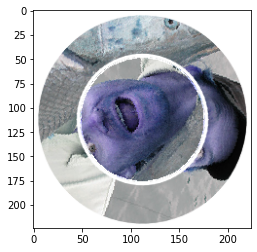

In [ ]:
import matplotlib.pyplot as plt

sample = dataset[314]
plt.imshow(sample[0].permute(1, 2, 0))
print(sample[1])

In [ ]:
import torch

BATCH_SIZE=256
# Random split of 80:20 between training and validation
num_items = len(dataset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, test_ds = random_split(dataset, [num_train, num_val])

# Create training and validation data loaders
# batch_size jak dobierac spradzic
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Funkcje strat modele itd

*   Najpierw zrobic na malym resnecie
*   Potem od 0 scratch swoj model wytrenowac





```
nn.CrossEntropyLoss combines log_softmax and NLLLoss which means you should not apply softmax at the end of your network output.
So you are not required to apply softmax since the criterion takes care of it.

If you want to use softmax at the end, then you should apply log after that(as you mentioned above) and use NLLLoss as the criterion.
```

## zmienic dol funkcji zeby wyrzucalo prawdopodobienstwa a nie wyniki

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class EmbeddingNet(nn.Module):
    def __init__(self, latent_dim=128, architecture=18):
        super(EmbeddingNet, self).__init__()
        self.architecture = architecture
        self.feature_extractor = self._getResnet(latent_dim=latent_dim)

    def forward(self, x):
        x = self.feature_extractor(x)
        return x

    def _getResnet(self,latent_dim):
        '''
        Sprawdzic czy daje tez FC
        '''
        if self.architecture == 18:
            model = models.resnet18(pretrained=True)
        elif self.architecture == 34:
            model = models.resnet34(pretrained=True)
        elif self.architecture == 50:
            model = models.resnet50(pretrained=True)
        elif self.architecture == 101:
            model = models.resnet101(pretrained=True)
        elif self.architecture == 152:
            model = models.resnet152(pretrained=True)
        else: print("MODEL NOT LOADED")
        
        for param in model.parameters():
            param.requires_grad= False # freeze beggining layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, latent_dim)
    


        return model

    def get_embedding(self, x):
        return self.forward(x)

class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes, latent_dim):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.latent_dim = latent_dim
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(latent_dim, n_classes) # 

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

embed_model = EmbeddingNet(latent_dim=512, architecture=18)
x = torch.randn(1, 3, 224, 224)
output = embed_model(x)
print(output.shape)

classifi = ClassificationNet(embed_model, n_classes=2, latent_dim=512)
x = torch.randn(1, 3, 64, 344)
output_class = classifi(x)
print(output_class.shape)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

torch.Size([1, 512])
torch.Size([1, 2])


# OLD TRAINING LOOP

In [ ]:
from tqdm import tqdm

def angle_error(y_true, y_pred):
    '''
    PRzepisac to na bardziej pytorchowe podejscie np
    Mse loss dummy
    def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss
    
    '''
    #print(y_true)
    #print(y_true.shape)
    ##print(y_pred)
    #print(y_pred.shape)
    error = torch.mean(torch.abs(y_true - y_pred))#.item() czy zadziala
    return error

def train_epoch(train_loader, optimizer, device, model, loss_fn, log_interval):
    '''
    Przepisac sobie zeby bylo bardziej czytelne
    '''
    running_loss = 0.
    train_loss = 0.
    #angle_loss = 0.
    #running_angle_loss = 0.
    for i, data in tqdm(enumerate(train_loader)):
        images, labels = data
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images)
        loss = loss_fn(preds, labels)
        #angle_error = metric(labels, preds)
        loss.backward() # Calculates the backward gradients over the learning weights

        optimizer.step() # Tells the optimizer to perform one learning step - that is, adjust the model’s learning weights
                         # based on the observed gradients for this batch, according to the optimization algorithm we chose It
                         #  reports on the loss for every log_interval. (log_interval = 500) -> every 500 batches
        running_loss += loss.item()
        #running_angle_loss += angle_error
        if i % log_interval == 0:
            train_loss = running_loss / loss # loss per batch
            #angle_loss = 
            print('  batch {} loss: {}'.format(i + 1, train_loss))
            running_loss = 0.
    return train_loss # loss calej epoki

def test_epoch(test_loader, model, device, loss_fn, save_best=True):
    '''
    OUTPUT
    jesli chce sie dokladnosc w procentach to pomnozyc correct * 100 !

    Metric nie moze byc None
    '''
    best_accuracy = 0
    test_loss = 0
    angle_loss = 0
    correct = 0
    size = len(test_loader.dataset) # ? czy to naprwno tak sprawdzic
    num_batches = len(test_loader)  # ?
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            test_loss += loss_fn(preds, labels).item()
            angle_loss += angle_error(labels, preds.argmax(1).type(torch.float))
            correct += (preds.argmax(1) == labels).type(torch.float).sum().item()
    test_loss = test_loss / num_batches
    angle_loss = angle_loss / num_batches
    correct = correct / size
    if save_best is True:
        if correct > best_accuracy:
            torch.save(model, 'best-model.pt')
            torch.save(model.state_dict(), 'best-model-parameters.pt')
            best_accuracy = correct
    print("Accuracy {}, Test_loss {}".format(correct*100, test_loss))
    return correct, test_loss, angle_loss

def train_model(epoch, model, train_loader, test_loader, optimizer, device, loss_fn, scheduler, log_interval, save_best=False, start_epoch=0):
    for i in range(0, start_epoch): # po co ? bo dziala od ktorejs epoki czasami !!!
        scheduler.step()
    
    train_loss_tab = []
    test_loss_tab = []
    accuracy_tab = []
    angle_loss_tab = []
    for i in range(start_epoch, epoch):
        train_loss = train_epoch(train_loader, optimizer, device, model, loss_fn, log_interval)
        accuracy, test_loss, angle_loss = test_epoch(test_loader, model, device, loss_fn)
        scheduler.step()
        train_loss_tab.append(train_loss)
        test_loss_tab.append(test_loss)
        accuracy_tab.append(accuracy)
        angle_loss_tab.append(angle_loss)
    return train_loss_tab, test_loss_tab, accuracy_tab, angle_loss_tab



In [ ]:
import torch.optim.lr_scheduler
import torch.optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

latent_dim = 512

embedding_model = EmbeddingNet(latent_dim=latent_dim, architecture=18).to(device)
model_classification = ClassificatbionNet(embedding_model, 360, latent_dim=latent_dim).to(device)

loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = torch.optim.Adam(model_classification.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 16
log_interval = 50 # ?


cuda:0


In [ ]:
train_tab, test_tab, acc_tab, angle_tab = train_model(epoch=n_epochs,
                                           model=model_classification,
                                           train_loader=train_dl,
                                           test_loader=test_dl,
                                           optimizer=optimizer,
                                           device=device,
                                           loss_fn=loss_fn,
                                           scheduler=scheduler,
                                           log_interval=100, # to lepiej ogarnac
                                           save_best=True,
                                           start_epoch=0)
# 25min 1 epoka na resnet  50  - 30 sek dane
# 24:47 start 15min  epoka jakos
# preprocess danych nie jest nma gpu chyba dlatego tak dlugo to trwa

1it [00:02,  2.23s/it]

  batch 1 loss: 1.0


101it [03:55,  2.28s/it]

  batch 101 loss: 112.66202545166016


111it [04:18,  2.33s/it]


Accuracy 0.31201248049922, Test_loss 5.888707569667271


1it [00:03,  3.23s/it]

  batch 1 loss: 1.0


101it [03:55,  2.51s/it]

  batch 101 loss: 100.01631164550781


111it [04:17,  2.32s/it]


Accuracy 0.18437101120408453, Test_loss 5.903605767658779


1it [00:02,  2.52s/it]

  batch 1 loss: 1.0


101it [04:01,  2.64s/it]

  batch 101 loss: 99.946533203125


111it [04:22,  2.36s/it]


Accuracy 0.32619486597645725, Test_loss 5.886572088514056


1it [00:02,  2.44s/it]

  batch 1 loss: 0.9999999403953552


101it [03:58,  2.32s/it]

  batch 101 loss: 99.98365020751953


111it [04:21,  2.35s/it]


Accuracy 0.22691816763579634, Test_loss 5.893081784248352


1it [00:02,  2.35s/it]

  batch 1 loss: 0.9999999403953552


101it [04:00,  2.31s/it]

  batch 101 loss: 100.17877197265625


111it [04:22,  2.37s/it]


Accuracy 0.2694653240675081, Test_loss 5.895130412919181


1it [00:02,  2.84s/it]

  batch 1 loss: 1.0


101it [04:00,  2.37s/it]

  batch 101 loss: 100.14114379882812


111it [04:23,  2.37s/it]


Accuracy 0.2978300950219827, Test_loss 5.906371423176357


1it [00:02,  2.26s/it]

  batch 1 loss: 1.0


101it [04:07,  2.32s/it]

  batch 101 loss: 100.24642944335938


111it [04:29,  2.43s/it]


Accuracy 0.1985533966813218, Test_loss 5.890559792518616


1it [00:02,  2.63s/it]

  batch 1 loss: 0.9999999403953552


101it [04:24,  3.16s/it]

  batch 101 loss: 100.01697540283203


111it [04:51,  2.63s/it]


Accuracy 0.2694653240675081, Test_loss 5.891628537859235


1it [00:02,  2.45s/it]

  batch 1 loss: 1.0


101it [04:05,  2.36s/it]

  batch 101 loss: 99.86168670654297


111it [04:29,  2.43s/it]


Accuracy 0.42547156431711813, Test_loss 5.888744183949062


1it [00:02,  2.57s/it]

  batch 1 loss: 1.0


101it [04:04,  2.45s/it]

  batch 101 loss: 100.01770782470703


111it [04:29,  2.43s/it]


Accuracy 0.28364770954474544, Test_loss 5.888250572340829


1it [00:02,  2.32s/it]

  batch 1 loss: 1.0


101it [04:05,  2.34s/it]

  batch 101 loss: 99.9466781616211


111it [04:28,  2.42s/it]


Accuracy 0.17018862572684726, Test_loss 5.887886881828308


1it [00:02,  2.34s/it]

  batch 1 loss: 1.0


101it [04:05,  2.34s/it]

  batch 101 loss: 99.99793243408203


111it [04:28,  2.42s/it]


Accuracy 0.2552829385902709, Test_loss 5.889327168464661


1it [00:02,  2.37s/it]

  batch 1 loss: 1.0


101it [04:06,  2.39s/it]

  batch 101 loss: 100.00434112548828


111it [04:29,  2.42s/it]


Accuracy 0.3403772514536945, Test_loss 5.889260275023324


1it [00:02,  2.51s/it]

  batch 1 loss: 1.0


101it [04:02,  2.31s/it]

  batch 101 loss: 99.97465515136719


111it [04:25,  2.39s/it]


Accuracy 0.3403772514536945, Test_loss 5.888248409543719


1it [00:02,  2.33s/it]

  batch 1 loss: 0.9999999403953552


101it [04:06,  2.61s/it]

  batch 101 loss: 100.01803588867188


111it [04:28,  2.42s/it]


Accuracy 0.1985533966813218, Test_loss 5.887247715677534


1it [00:02,  2.40s/it]

  batch 1 loss: 1.0


101it [04:04,  2.53s/it]

  batch 101 loss: 100.01655578613281


111it [04:26,  2.40s/it]


Accuracy 0.21273578215855907, Test_loss 5.8901302473885675


#### Pomyslu

16 epok - 1h:29min:30sek

1. wrzucic wiecej danych
2. naprawic test/train
3. sprawdzic czy rgb dziala tak jak ma dzialac
4. jakis fine-tuning
5. wiecej danych
6. inne modele niz resnet 18
7. sprawdzic modele inne niz z pytorch np. xgboost do klasyfikacji uzyc
8. vision transformer as feature extraction

#### tqdm sie zacial
1 epoka = 5min

In [ ]:
train_tab

[tensor(112.6620, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(100.0163, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(99.9465, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(99.9837, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(100.1788, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(100.1411, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(100.2464, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(100.0170, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(99.8617, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(100.0177, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(99.9467, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(99.9979, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(100.0043, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(99.9747, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(100.0180, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(100.0166, device='cuda:0', grad_fn=<MulBackward0>)]

In [ ]:
test_tab

[5.888707569667271,
 5.903605767658779,
 5.886572088514056,
 5.893081784248352,
 5.895130412919181,
 5.906371423176357,
 5.890559792518616,
 5.891628537859235,
 5.888744183949062,
 5.888250572340829,
 5.887886881828308,
 5.889327168464661,
 5.889260275023324,
 5.888248409543719,
 5.887247715677534,
 5.8901302473885675]

In [ ]:
acc_tab

[0.0031201248049922,
 0.0018437101120408453,
 0.0032619486597645726,
 0.0022691816763579634,
 0.0026946532406750814,
 0.002978300950219827,
 0.001985533966813218,
 0.0026946532406750814,
 0.004254715643171181,
 0.002836477095447454,
 0.0017018862572684725,
 0.002552829385902709,
 0.003403772514536945,
 0.003403772514536945,
 0.001985533966813218,
 0.0021273578215855907]

In [ ]:
angle_tab

[tensor(98.9869, device='cuda:0'),
 tensor(104.4315, device='cuda:0'),
 tensor(110.0421, device='cuda:0'),
 tensor(89.8380, device='cuda:0'),
 tensor(164.1226, device='cuda:0'),
 tensor(146.7888, device='cuda:0'),
 tensor(124.9868, device='cuda:0'),
 tensor(152.4188, device='cuda:0'),
 tensor(91.3188, device='cuda:0'),
 tensor(91.0491, device='cuda:0'),
 tensor(89.5375, device='cuda:0'),
 tensor(128.9952, device='cuda:0'),
 tensor(101.1165, device='cuda:0'),
 tensor(90.5410, device='cuda:0'),
 tensor(92.8527, device='cuda:0'),
 tensor(135.8764, device='cuda:0')]

#### Klasyfikacja 360 labeli (1 for each class)

Train_loss = 100

Test_loss = 5.9

accuracy = 0.003

angle_error = 89-164

Wnioski:

* zmienic i napisac od nowa funkcje trenujaca

#### Moze z tymi labelami co wymyslilem 

* 0 normalne bez angle
* 1 zrotowane

bo nie chodzi mi o wykrywanie dokladnego kata tylko memntu w ktorym jest 0 !

na logike czlowiek tez nie stwierdzi z duza dokladnoscia katu obrotu ale stwierdzi zawsze kiedy jest dobrze 

#### Triplet loss solution

1. train triplet loss model
2. 360 labels, where pairs are made like:

* anchor (10 degree) , positive (10 degree), negative (25 degree)


use e.g. 10k examples and torch.mean them to get ideal (0 degree feature vector) like in Stylegan

* embedd production image and predict angle

# NEW TRAINING LOOP

In [ ]:
class EarlyStopping():
    '''
    Method for avoid ofervitting by stopping when test loss doesn't decrease

    '''
    def __init__(self, old_loss=float('inf'), patience=5, delta=0.001, mode="simple", save=False):
        '''
        Attributes
        ---------------------

        old_loss: float
            ON START IS EQUAL TO PLUS INFINITY
            loss from last epoch
            On metric you can use test loss, acc or your own idea

        patience: int
            number of epochs to check until break training
        
        delta: float
            A minimum increase in the score to qualify as an improvement,
            i.e. an increase of less than or equal to min_delta,
            will count as no improvement.
        
        mode: str
            if 'simple' model stop train when loss doesn't decrease 
            patience time.

        save: bool
            If True Saves best model every epoch
            if epoch before was better don't overwrite
            SAVE MODEL WITH SHAPE NOT ONLY WEIGHTS

        Parameters
        --------------------
        counter: int 0 
            If counter reach patience stop training
        
        best_loss: float
            save best weights
        '''
        self.old_loss = old_loss
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.save = save
        self.counter = 0
        self.best_loss = float('inf')

    def run(self, new_loss, model=None):
        '''
        Attributes
        ------------------------
        model: (check)
            model to save weights
        new_loss: float
            new loss after test

        Returns
        -------------------
        bool:
            True if training should stop
        
        best model parameters or saved file 
        '''
        if new_loss < self.old_loss:
            if (self.old_loss - new_loss) <= self.delta: # TU POWINNO BYC BEST LOSS ZAMIAST OLD LOSS (niekoniecznie)
                self.counter += 1 
            else:
                # jesli sie zmiejszyl o wiecej niz delta to wyzeruj counter
                self.counter = 0
            self.old_loss = new_loss
        elif new_loss > self.old_loss:
            # dodaj do countera
            self.counter += 1
        
        # save best model
        if self.save is True:
            if new_loss <= self.best_loss: # tutaj pomiesane bo nie zapisze po 1 razie tylko po kolejnych
                #print("nowy loss mniejszy niz stary wiec nadpisuje best")
                self.best_loss = new_loss
                #print(f"ZAPISUJE MODEL Z TEST LOSS: {self.best_loss}")
                torch.save(model, 'best_model.pth')
                

        # stop training
        if self.counter >= self.patience:
            return True
        
        return False



In [ ]:
from tqdm import tqdm
import numpy as np
import time

# CUDA automatyczne wykrywanie dodac
# log intervals+

def calculate_log_interval(dataloader, percent=10):
    '''
    Attributes
    --------------------------
    if percent == 10, log will be printed every 10% of dataset

    no nie do konca takto bedzie dzialac xd
    '''
    num_batches = len(dataloader)
    p = lambda x : x/100
    calc_per = p(percent)
    result = int(num_batches*calc_per)
    print(f"Number of batches in dataset: {num_batches}, for percent: {percent}, log_interval is: {result}")
    return result


def train_function(model, loss_fn, optimizer, dataloader, log_interval=None):
    '''
    Function for training one epoch in model

    Parameters
    -------------------------------
    epoch : int
        Number of epochs to train the model
    
    model : (sprawdzic)
        Neural network model to train

    loss_fn : (check)
        Function which compute loss
    
    optimizer : (check)
        Optimizer adjust learnable parameters
    
    dataloader : (torch.utils..)
        TRAIN dataloader

    log_interval: int
        if 10 log interval wiill be printed every 10 batches

    Attributes
    ------------------------------
    X, y : torch.Tensor
        data and label (n_samples, in_channels, img_size, img_size)
    
    loss : (check)
        computed loss

    Returns
    -----------------------
    logits : torch.Tensor
        Logits over all the classes - '(n_smaples, n_classes)'
    '''
    interval_loss = []
    model.train()
    train_loss = 0.
    num_batches = len(dataloader)
    #log_interval = int((len(dataloader.dataset) % log_interval))
    for i, (data, label) in tqdm(enumerate(dataloader), position=0, leave=True, total=len(dataloader)):
        data = data.to(device)
        label = label.to(device)
        # 1. clear gradients
        model.zero_grad()

        # 2. forward pass
        label_pred = model(data)

        # 3. compute loss
        loss = loss_fn(label_pred, label)

        # 4. compute gradients
        loss.backward()

        # 5. adjust learnable parameters
        optimizer.step()

        train_loss += loss.item()
        if log_interval is not None:
            if i % log_interval == 0:
                tqdm.write(f"For batch: 0-{i+1} train_loss: {train_loss/(i+1)}")
                interval_loss.append(train_loss/(i+1))
            
    train_loss /= num_batches
    return train_loss, interval_loss
    


def test_function(model, loss_fn, dataloader):
    '''
    Test one epoch in model
    Function for training one epoch in model

    Parameters
    -------------------------------
    model : (sprawdzic)
        Neural network model to train

    loss_fn : (check)
        Function which compute loss
    
    dataloader : (torch.utils..)
        TEST dataloader
    

    Attributes
    ------------------------------
    X, y : torch.Tensor
        data and label (n_samples, in_channels, img_size, img_size)
    
    loss : (check)
        computed loss

    Returns
    -----------------------
    logits : torch.Tensor
        Logits over all the classes - '(n_smaples, n_classes)'
    '''
    model.eval()
    correct = 0.
    test_loss = 0.
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    with torch.no_grad():
        for data, label in tqdm(dataloader, position=0, leave=True):
            data = data.to(device)
            label = label.to(device)
            preds = model(data)
            correct += (preds.argmax(1) == label).type(torch.float).sum().item()
            test_loss += loss_fn(preds, label).item()
    test_loss /= num_batches
    accuracy = correct/size
    return test_loss, accuracy


def train_model(epoch: int, model, loss_fn, optimizer, train_dataloader, test_dataloader, scheduler=None, start_epoch=0, log_interval=None, patience=3):
    '''
    Attributes
    ---------------------
    log interval: int
        if 10 log interval wiill be printed every 10% of dataset
    '''
    if scheduler is not None:
        for i in range(0, start_epoch): # po co ? bo dziala od ktorejs epoki czasami !!!
            scheduler.step()
    
    all_interval_losses = [] # nie np array poniewaz roznie to moze wychodzic z iloscia batch
    stop_training = EarlyStopping(patience=patience, save=True)
    base_loss = test_function(model, loss_fn, test_dataloader) # check loss without training
    train_loss = np.zeros(epoch)
    test_loss = np.zeros(epoch)
    acc_tab = np.zeros(epoch)
    for i in range(epoch):
        start_time = time.time()
        train_loss[i], interval_loss = train_function(model, loss_fn, optimizer, train_dataloader, log_interval)
        t_train = time.time() - start_time
        test_loss[i], acc_tab[i] = test_function(model, loss_fn, test_dataloader)
        t_test = time.time() - t_train - start_time

        all_interval_losses.append(interval_loss)
        if scheduler is not None:
            scheduler.step()

        print(f"EPOCH: {i+1},  TRAIN LOSS: {round(train_loss[i],5)}, TEST LOSS: {round(test_loss[i],5)}, ACCURACY: {acc_tab[i]} TRAIN/TEST TIME: {round(t_train, 3)}/{round(t_test, 3)} sec \n")
        decision = stop_training.run(test_loss[i], model)

        if decision == True:
            print("TRAINING STOP")
            # remove 0s from array
            train_loss = np.trim_zeros(train_loss, 'b')
            test_loss = np.trim_zeros(test_loss, 'b')
            acc_tab = np.trim_zeros(acc_tab, 'b')
            break
            
    return train_loss, test_loss, acc_tab, base_loss, all_interval_losses

xd = calculate_log_interval(train_dl, percent=10)

Number of batches in dataset: 111, for percent: 10, log_interval is: 11


In [ ]:
import torch.optim.lr_scheduler
import torch


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
epoch=16
latent_dim = 512
learning_rate = 0.01
momentum = 0.5



embedding_model = EmbeddingNet(latent_dim=latent_dim, architecture=18).to(device)
model_classification = ClassificationNet(embedding_model, 360, latent_dim=latent_dim).to(device)

hinge_loss = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(model_classification.parameters(), lr=learning_rate,
                      momentum=momentum) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

train_loss, test_loss, acc_tab, base_loss, all_interval_losses = train_model(epoch, model_classification, hinge_loss,
                                                                             optimizer, train_dl, test_dl, scheduler, start_epoch=0, log_interval=11, patience=3)

base_loss = base_loss[0]

cuda:0


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  1%|          | 1/111 [00:02<05:09,  2.81s/it]

For batch: 0-1 train_loss: 6.000563621520996


 11%|█         | 12/111 [00:31<04:16,  2.59s/it]

For batch: 0-12 train_loss: 2.1067096491654715


 21%|██        | 23/111 [00:58<03:37,  2.47s/it]

For batch: 0-23 train_loss: 1.4253560071406157


 31%|███       | 34/111 [01:26<03:15,  2.54s/it]

For batch: 0-34 train_loss: 1.1677752610515146


 41%|████      | 45/111 [01:55<03:02,  2.76s/it]

For batch: 0-45 train_loss: 1.0352376010682849


 50%|█████     | 56/111 [02:33<03:17,  3.58s/it]

For batch: 0-56 train_loss: 0.9490085606064115


 60%|██████    | 67/111 [03:06<02:03,  2.81s/it]

For batch: 0-67 train_loss: 0.8880655729948584


 70%|███████   | 78/111 [03:35<01:26,  2.61s/it]

For batch: 0-78 train_loss: 0.8418965538342794


 80%|████████  | 89/111 [04:07<01:03,  2.91s/it]

For batch: 0-89 train_loss: 0.8057232425453957


 90%|█████████ | 100/111 [04:36<00:27,  2.52s/it]

For batch: 0-100 train_loss: 0.7758930951356888


100%|██████████| 111/111 [05:01<00:00,  2.72s/it]


For batch: 0-111 train_loss: 0.7515386834337905


100%|██████████| 28/28 [01:12<00:00,  2.58s/it]


EPOCH: 1,  TRAIN LOSS: 0.75154, TEST LOSS: 0.51656, ACCURACY: 0.7607431569990072 TRAIN/TEST TIME: 301.939/72.276 sec 



  1%|          | 1/111 [00:02<04:12,  2.29s/it]

For batch: 0-1 train_loss: 0.5098070502281189


 11%|█         | 12/111 [00:28<03:57,  2.40s/it]

For batch: 0-12 train_loss: 0.5122426152229309


 21%|██        | 23/111 [00:55<03:35,  2.45s/it]

For batch: 0-23 train_loss: 0.51615335241608


 31%|███       | 34/111 [01:21<03:02,  2.37s/it]

For batch: 0-34 train_loss: 0.511551162775825


 41%|████      | 45/111 [01:48<02:41,  2.45s/it]

For batch: 0-45 train_loss: 0.5098948021729787


 50%|█████     | 56/111 [02:14<02:12,  2.40s/it]

For batch: 0-56 train_loss: 0.510816117482526


 60%|██████    | 67/111 [02:41<01:43,  2.36s/it]

For batch: 0-67 train_loss: 0.5121598430533907


 70%|███████   | 78/111 [03:13<01:40,  3.04s/it]

For batch: 0-78 train_loss: 0.5083781969852936


 80%|████████  | 89/111 [03:40<00:54,  2.49s/it]

For batch: 0-89 train_loss: 0.5054394221037961


 90%|█████████ | 100/111 [04:08<00:27,  2.51s/it]

For batch: 0-100 train_loss: 0.5044400849938393


100%|██████████| 111/111 [04:34<00:00,  2.47s/it]


For batch: 0-111 train_loss: 0.5031328171760112


100%|██████████| 28/28 [01:07<00:00,  2.40s/it]


EPOCH: 2,  TRAIN LOSS: 0.50313, TEST LOSS: 0.49588, ACCURACY: 0.7672670543185364 TRAIN/TEST TIME: 274.621/67.121 sec 



  1%|          | 1/111 [00:02<04:01,  2.19s/it]

For batch: 0-1 train_loss: 0.5171786546707153


 11%|█         | 12/111 [00:27<03:48,  2.30s/it]

For batch: 0-12 train_loss: 0.49180255581935245


 21%|██        | 23/111 [00:55<03:37,  2.47s/it]

For batch: 0-23 train_loss: 0.4808280040388522


 31%|███       | 34/111 [01:21<03:04,  2.40s/it]

For batch: 0-34 train_loss: 0.487088482169544


 41%|████      | 45/111 [01:47<02:33,  2.32s/it]

For batch: 0-45 train_loss: 0.4835367010699378


 50%|█████     | 56/111 [02:12<02:07,  2.32s/it]

For batch: 0-56 train_loss: 0.4882758611014911


 60%|██████    | 67/111 [02:37<01:40,  2.28s/it]

For batch: 0-67 train_loss: 0.4859785722262824


 70%|███████   | 78/111 [03:03<01:16,  2.31s/it]

For batch: 0-78 train_loss: 0.4845294570311522


 80%|████████  | 89/111 [03:29<00:51,  2.33s/it]

For batch: 0-89 train_loss: 0.48410268211632634


 90%|█████████ | 100/111 [03:56<00:28,  2.56s/it]

For batch: 0-100 train_loss: 0.4815655428171158


100%|██████████| 111/111 [04:20<00:00,  2.35s/it]


For batch: 0-111 train_loss: 0.4801253797234716


100%|██████████| 28/28 [01:03<00:00,  2.26s/it]


EPOCH: 3,  TRAIN LOSS: 0.48013, TEST LOSS: 0.47009, ACCURACY: 0.7794639058289604 TRAIN/TEST TIME: 260.31/63.33 sec 



  1%|          | 1/111 [00:02<04:27,  2.43s/it]

For batch: 0-1 train_loss: 0.4928623139858246


 11%|█         | 12/111 [00:28<04:02,  2.45s/it]

For batch: 0-12 train_loss: 0.4888111750284831


 21%|██        | 23/111 [00:53<03:27,  2.36s/it]

For batch: 0-23 train_loss: 0.47718415700871014


 31%|███       | 34/111 [01:19<02:56,  2.29s/it]

For batch: 0-34 train_loss: 0.46835781370892243


 41%|████      | 45/111 [01:45<02:38,  2.40s/it]

For batch: 0-45 train_loss: 0.4673102729850345


 50%|█████     | 56/111 [02:11<02:05,  2.28s/it]

For batch: 0-56 train_loss: 0.46769242361187935


 60%|██████    | 67/111 [02:36<01:41,  2.30s/it]

For batch: 0-67 train_loss: 0.46590984623823595


 70%|███████   | 78/111 [03:01<01:16,  2.30s/it]

For batch: 0-78 train_loss: 0.46422032591624135


 80%|████████  | 89/111 [03:27<00:52,  2.37s/it]

For batch: 0-89 train_loss: 0.4646584696314308


 90%|█████████ | 100/111 [03:52<00:25,  2.29s/it]

For batch: 0-100 train_loss: 0.464491585791111


100%|██████████| 111/111 [04:16<00:00,  2.31s/it]


For batch: 0-111 train_loss: 0.46361615072499524


100%|██████████| 28/28 [01:04<00:00,  2.30s/it]


EPOCH: 4,  TRAIN LOSS: 0.46362, TEST LOSS: 0.45077, ACCURACY: 0.7892497518082542 TRAIN/TEST TIME: 256.276/64.527 sec 



  1%|          | 1/111 [00:02<04:46,  2.61s/it]

For batch: 0-1 train_loss: 0.4452858567237854


 11%|█         | 12/111 [00:27<03:46,  2.29s/it]

For batch: 0-12 train_loss: 0.4547366152207057


 21%|██        | 23/111 [00:53<03:26,  2.34s/it]

For batch: 0-23 train_loss: 0.4688150221886842


 31%|███       | 34/111 [01:19<03:05,  2.41s/it]

For batch: 0-34 train_loss: 0.4638924397089902


 41%|████      | 45/111 [01:45<02:39,  2.42s/it]

For batch: 0-45 train_loss: 0.4616082919968499


 50%|█████     | 56/111 [02:11<02:07,  2.32s/it]

For batch: 0-56 train_loss: 0.4599488803318569


 60%|██████    | 67/111 [02:37<01:39,  2.27s/it]

For batch: 0-67 train_loss: 0.45781141074735726


 70%|███████   | 78/111 [03:03<01:17,  2.33s/it]

For batch: 0-78 train_loss: 0.4583265001957233


 80%|████████  | 89/111 [03:29<00:52,  2.40s/it]

For batch: 0-89 train_loss: 0.45972713895058365


 90%|█████████ | 100/111 [03:55<00:24,  2.26s/it]

For batch: 0-100 train_loss: 0.45833713829517364


100%|██████████| 111/111 [04:18<00:00,  2.33s/it]


For batch: 0-111 train_loss: 0.4558121070668504


100%|██████████| 28/28 [01:03<00:00,  2.28s/it]


EPOCH: 5,  TRAIN LOSS: 0.45581, TEST LOSS: 0.49521, ACCURACY: 0.7645724010778613 TRAIN/TEST TIME: 258.439/63.78 sec 



  1%|          | 1/111 [00:02<04:02,  2.20s/it]

For batch: 0-1 train_loss: 0.4825440049171448


 11%|█         | 12/111 [00:28<03:56,  2.39s/it]

For batch: 0-12 train_loss: 0.4473559334874153


 21%|██        | 23/111 [00:55<03:24,  2.32s/it]

For batch: 0-23 train_loss: 0.4546309748421545


 31%|███       | 34/111 [01:20<02:55,  2.28s/it]

For batch: 0-34 train_loss: 0.45401422416462617


 41%|████      | 45/111 [01:46<02:31,  2.29s/it]

For batch: 0-45 train_loss: 0.45101853675312464


 50%|█████     | 56/111 [02:12<02:14,  2.44s/it]

For batch: 0-56 train_loss: 0.4564451090991497


 60%|██████    | 67/111 [02:37<01:38,  2.24s/it]

For batch: 0-67 train_loss: 0.45587749267691996


 70%|███████   | 78/111 [03:03<01:20,  2.44s/it]

For batch: 0-78 train_loss: 0.4574736773203581


 80%|████████  | 89/111 [03:29<00:51,  2.35s/it]

For batch: 0-89 train_loss: 0.4584126646599073


 90%|█████████ | 100/111 [03:55<00:26,  2.45s/it]

For batch: 0-100 train_loss: 0.4566072705388069


100%|██████████| 111/111 [04:18<00:00,  2.33s/it]


For batch: 0-111 train_loss: 0.4549467536780211


100%|██████████| 28/28 [01:04<00:00,  2.30s/it]


EPOCH: 6,  TRAIN LOSS: 0.45495, TEST LOSS: 0.48691, ACCURACY: 0.755353850517657 TRAIN/TEST TIME: 258.892/64.47 sec 



  1%|          | 1/111 [00:02<04:27,  2.43s/it]

For batch: 0-1 train_loss: 0.5383523106575012


 11%|█         | 12/111 [00:28<03:50,  2.33s/it]

For batch: 0-12 train_loss: 0.44387224813302356


 21%|██        | 23/111 [00:53<03:21,  2.29s/it]

For batch: 0-23 train_loss: 0.44940917258677276


 31%|███       | 34/111 [01:18<02:55,  2.28s/it]

For batch: 0-34 train_loss: 0.4440334991497152


 41%|████      | 45/111 [01:45<02:41,  2.45s/it]

For batch: 0-45 train_loss: 0.441827169391844


 50%|█████     | 56/111 [02:10<02:05,  2.28s/it]

For batch: 0-56 train_loss: 0.4444893492119653


 60%|██████    | 67/111 [02:36<01:43,  2.34s/it]

For batch: 0-67 train_loss: 0.4468380470774067


 70%|███████   | 78/111 [03:01<01:13,  2.23s/it]

For batch: 0-78 train_loss: 0.4424378615923417


 80%|████████  | 89/111 [03:27<00:52,  2.40s/it]

For batch: 0-89 train_loss: 0.44515744186519235


 90%|█████████ | 100/111 [03:53<00:25,  2.31s/it]

For batch: 0-100 train_loss: 0.4485555058717728


100%|██████████| 111/111 [04:17<00:00,  2.32s/it]


For batch: 0-111 train_loss: 0.44914107413979265


100%|██████████| 28/28 [01:04<00:00,  2.31s/it]

EPOCH: 7,  TRAIN LOSS: 0.44914, TEST LOSS: 0.48756, ACCURACY: 0.7727981846546589 TRAIN/TEST TIME: 257.188/64.677 sec 

TRAINING STOP


LOWEST TRAIN_LOSS: 0.44914107413979265
LOWEST TEST_LOSS: 0.4507680907845497
HIGHREST ACCURACY: 0.7892497518082542


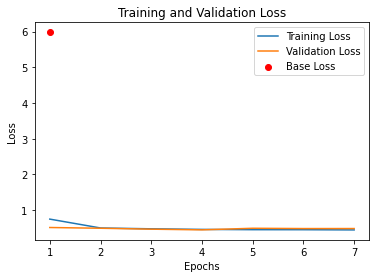

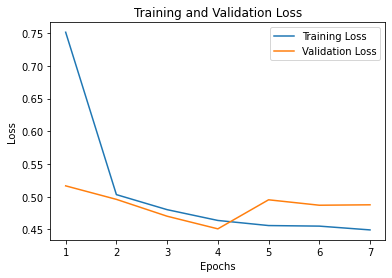

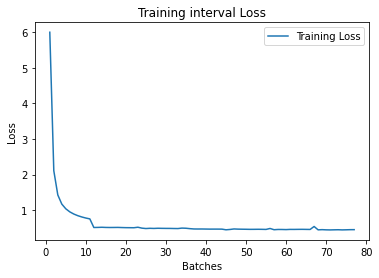

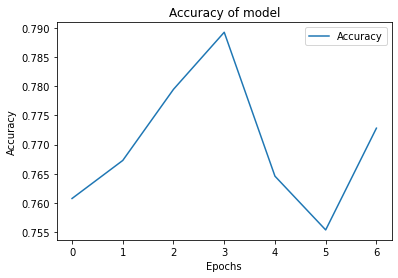

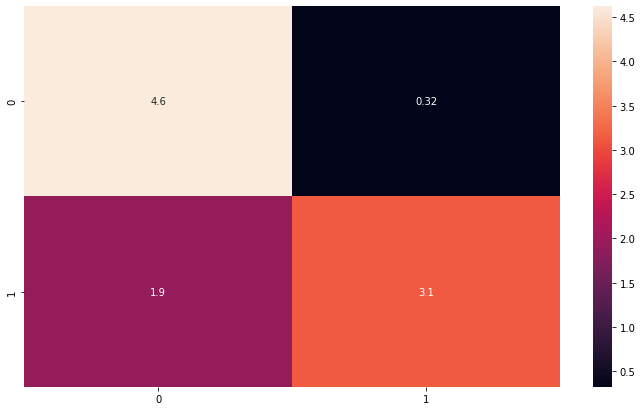

In [ ]:
import matplotlib.pyplot as plt
from numpy import arange
# plot data
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


def plot_data(train_loss, test_loss, base_loss=None):
    '''
    Plot train and test loss
        loss without training
    base_loss

    '''
    num_epoch = [i for i in range(1,len(train_loss)+1)]
    plt.plot(num_epoch, train_loss, label='Training Loss')
    plt.plot(num_epoch, test_loss, label='Validation Loss')
    if base_loss != None:
        plt.scatter(1, base_loss, color='red', label='Base Loss')
    # Add in a title and axes labels
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Set the tick locations
    plt.xticks(arange(1, len(train_loss)+1))
    
    # Display the plot
    plt.legend(loc='best')
    plt.show()



def plot_interval_loss(interval_loss):
    #flatten interval loss
    interval_loss=[element for sublist in interval_loss for element in sublist]
    num_intervals = [i for i in range(1,len(interval_loss)+1)]
    plt.plot(num_intervals, interval_loss, label='Training Loss')
    plt.title('Training interval Loss')
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()



def plot_confusion_matrix(test_loader, model, save=False):
    y_pred = []
    y_true = []

    # iterate over test data
    for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            output = model(inputs) # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            #print(output)
            y_pred.extend(output) # Save Prediction
            
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

    # constant for classes
    classes = ('0', '1')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    #print(cf_matrix)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                        columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    if save is True:
        plt.savefig('output.png')


def plot_accuracy(acc_tab=acc_tab):
    length = [i for i in range(len(acc_tab))]
    plt.plot(length, acc_tab, label='Accuracy')
    plt.title('Accuracy of model')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show() 

def print_best(train_loss=train_loss, test_loss=test_loss, acc_tab=acc_tab):
    '''
    Dodac dla ktorej epoki najlepsze wyniki dla ktorego
    '''
    print(f"LOWEST TRAIN_LOSS: {min(train_loss)}")
    print(f"LOWEST TEST_LOSS: {min(test_loss)}")
    print(f"HIGHREST ACCURACY: {max(acc_tab)}")

print_best()
plot_data(train_loss, test_loss, base_loss)
plot_data(train_loss, test_loss)
plot_interval_loss(all_interval_losses)
plot_accuracy()
plot_confusion_matrix(test_dl, model_classification)





# EDA dla ktorych katow wyrzuca bledy

* i do funkcji testowej dodac pokazywanie dla ktorych katow jak sobie radzi
* na tej podstawie pomyslec z zamiana random na dystrybuje normalna czy inny sposob (cos jak branie batch hard online mining w facenet)

In [ ]:
# plot my own confusion matrix

def my_plot_confusion_matrix(test_loader, model):
    '''
    Attributes
    -------------------------
    test_loader:
    
    model:

    Parameters
    --------------------------
    y_true: list
        true labels
        
    y_pred: list
        predicted labels
    
    tp: int
        True Positive values
        
    tn: int
        True Negative values
    
    fp: int
        False Positive values
    
    fn: int
        False Negative values
        
        ACTUAL
         1  0
   P  1 TP FP
   R  0 FN TN
   E  
   D 
      
   
    Returns
    tp, fp, fn, tn : int
    ------------------------------
    
    '''
    y_pred = []
    y_true = []

    # iterate over test data
    for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            output = model(inputs) # Feed Network

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            #print(output)
            y_pred.extend(output) # Save Prediction
            
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth



    tp=0
    tn=0
    fp=0
    fn=0
    
    for el1, el2 in zip(y_true,y_pred):
        if el1 == el2 and el1 == 1:
            tp += 1
        elif  el1 == el2 and el1 == 0:
            tn += 1
        elif el1 == 1 and el1 != el2:
            fn += 1
        elif el1 == 0 and el1 != el2:
            fp += 1
    
    
    conf_matrix = np.array((tn, fn, fp, tp))
    conf_matrix = conf_matrix.reshape((2,2)) # bad shape ale dobry wychodzi w matplotlib xd (fuszera)
    #print(conf_matrix)
    
    len_dataset = np.sum(conf_matrix)
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            percentage = round((conf_matrix[i, j]/len_dataset)*100,2)
            text = f'''{conf_matrix[i, j]} val
{percentage} %'''
            ax.text(x=j, y=i,s=text, va='center', ha='center', size='xx-large')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.xlabel('Confusion Matrix', fontsize=18)
    plt.ylabel('Predictions', fontsize=18)
    plt.title('Actual', fontsize=18)
    plt.show()
    
